In [4]:
%cd C:\Users\james\OneDrive\Documents\Machine Learning\Terrorism

C:\Users\james\OneDrive\Documents\Machine Learning\Terrorism


In [381]:
%pwd

'C:\\Users\\james\\OneDrive\\Documents\\Machine Learning\\Terrorism'

In [322]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

In [6]:
import sys
sys.path.append('C:\\Users\james\OneDrive\Documents\Machine Learning\Terrorism')

In [260]:
from DBA import DBA_multivariate as DBA
from tslearn.metrics import dtw, dtw_path, cdist_dtw
from sklearn.cluster import AgglomerativeClustering
from tslearn.clustering import KShape
from sklearn.metrics import silhouette_score

In [9]:
df = pd.read_csv('Ter_Time_Series.csv')
df.sort_values(['country_txt', 'iyear'], inplace = True)
df.set_index(['country_txt'], inplace = True, drop = True)

In [382]:
to_keep = []
for country in df.index.unique():
    if 1980 in df.loc[country]['iyear'].values:
        to_keep.append(country)
df1 = df.loc[to_keep]    

features = ['suicide', 'attacktype1_txt_Armed Assault',
       'attacktype1_txt_Assassination', 'attacktype1_txt_Bombing/Explosion',
       'attacktype1_txt_Facility/Infrastructure Attack',
       'attacktype1_txt_Hijacking',
       'attacktype1_txt_Hostage Taking (Barricade Incident)',
       'attacktype1_txt_Hostage Taking (Kidnapping)',
       'attacktype1_txt_Unarmed Assault', 'attacktype1_txt_Unknown',
       'weaptype1_txt_Biological', 'weaptype1_txt_Chemical',
       'weaptype1_txt_Explosives', 'weaptype1_txt_Fake Weapons',
       'weaptype1_txt_Firearms', 'weaptype1_txt_Incendiary',
       'weaptype1_txt_Melee', 'weaptype1_txt_Other',
       'weaptype1_txt_Radiological', 'weaptype1_txt_Sabotage Equipment',
       'weaptype1_txt_Unknown',
       'weaptype1_txt_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)',
       'targtype1_txt_Abortion Related', 'targtype1_txt_Airports & Aircraft',
       'targtype1_txt_Business', 'targtype1_txt_Educational Institution',
       'targtype1_txt_Food or Water Supply',
       'targtype1_txt_Government (Diplomatic)',
       'targtype1_txt_Government (General)',
       'targtype1_txt_Journalists & Media', 'targtype1_txt_Maritime',
       'targtype1_txt_Military', 'targtype1_txt_NGO', 'targtype1_txt_Other',
       'targtype1_txt_Police', 'targtype1_txt_Private Citizens & Property',
       'targtype1_txt_Religious Figures/Institutions',
       'targtype1_txt_Telecommunication',
       'targtype1_txt_Terrorists/Non-State Militia', 'targtype1_txt_Tourists',
       'targtype1_txt_Transportation', 'targtype1_txt_Unknown',
       'targtype1_txt_Utilities', 'targtype1_txt_Violent Political Party','success']

df1 = df1.loc[df1.iyear >=1980][['iyear']+features]


In [ ]:
#First Clustering technique we will use will be Agglomerative Clustering

In [383]:
#format for distance matrix
arr = np.array(df1[features]).reshape(108,39,45)
dtw_mat = cdist_dtw(arr)

In [134]:
AC = AgglomerativeClustering(affinity = 'precomputed', linkage = 'average',distance_threshold = 0,  n_clusters =None)
AC.fit(dtw_mat )
AC.labels_

array([103, 107,  53,  57,  80,  89,  84,  56,  87,  76,  91,  79,  99,
        77,  81, 102, 106,  82, 101,  73,  59,  75,  64,  71, 100,  72,
        66,  61,  58,  74,  50,  63,  49,  97,  40,  70,  60,  95,  55,
        88,  37,  96,  83,  47,  78,  98,  41,  39,  36,  27,  38, 105,
        48,  31,  62,  69,  35,  90,  24,  93, 104,  28,  44,  51,  85,
        30,  94,  43,  92,  19,  54,  46,  21,  13,  26,  67,  65,  52,
        18,  29,  86,  14,  45,  32,  17,  23,  42,  68,  22,  34,   8,
        11,  25,  20,   6,  12,  10,  33,  16,   9,   4,  15,   7,   5,
         3,   2,   1,   0], dtype=int64)

In [140]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

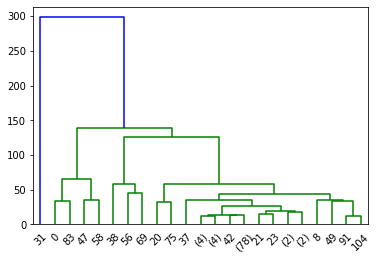

In [145]:
plot_dendrogram(AC, truncate_mode = 'level', p = 8)

The agglomerative method seems to result in one cluster representing a very high proportion of the dataset, with a handful of outliers ending up in other   
Linkage method doesn't seem to change much, generally end up with El Salvador on its own, Iraq on its own, Afghanistan, Somalia together and roughly 100 other countries together

Next Method will be Kmeans. Have decided to keep distance method constant as dtw, however will try different methods of finding centroids of the clusters.

Mean and Median raise issues when using a non-Euclidean distance metric, so I will be comparing how they do with a more time-series specific method proposed by Francois Petijohn, called DTW Bary-center Averaging. I will also compare these with k-medoids.

In [ ]:
#One challenge here is which method to use to find the centroids of the time series. First will try mean and median
#One of the drawbacks of mean and median are that can only compare series of the same length 

In [12]:
def centroid_mean(cluster, data):
    cluster_sum =0
    for k in cluster:
        cluster_sum += data.loc[k,features].values
    return [m/len(cluster) for m in cluster_sum]

In [13]:
def centroid_median(cluster, data):
    cluster_series = [data.loc[k, features].values for k in cluster]
    
    
    return np.median(cluster_series, axis = 0)


In [38]:
#DBA function requires time series to be in format (channels, time) so will have to swap axes twice
def centroid_DBA(cluster, data):
    cluster_series = np.array([data.loc[k, features].values for k in cluster])
    cluster_series = cluster_series.swapaxes(1,2)
    centroid = DBA.performDBA(cluster_series)
    return list(centroid.swapaxes(0,1))



In [154]:
def medoid(cluster, data):
    cluster_series = [data.loc[k, features].values for k in cluster]
    distance_mat = cdist_dtw(cluster_series)
    distance_sums = np.sum(distance_mat, axis = 0)
    medoid = np.argmin(distance_sums)
    return cluster_series[medoid]

Implemented this from scratch as didn't know about tslearn's TimeSeriesKmeans func

In [192]:
def array_of_labels(cluster_dic):
    res = np.zeros((len(df1.index.unique())), dtype = 'int')
    for key in cluster_dic.keys():
        for country in cluster_dic[key]:
            ind = list(df1.index.unique()).index(country)
            res[ind] = key
            
    return res

In [275]:
def kmeans(data, features,  n_clusters, centroid_func, steps):
    centroids_countries = random.sample(list(data.index.unique()), n_clusters)
    centroids = [data.loc[country][features].values for country in centroids_countries]
    current_step = 0
    
    for step in range(steps):
        current_step +=1
        clusters = {}
        
        for country in data.index.unique():
            min_dist = float('inf')
            closest_cluster = None
            
            for j, centroid in enumerate(centroids):
                dist = dtw(data.loc[country][features], centroid)
                if dist < min_dist:
                    min_dist = dist
                    closest_cluster = j
            
            if closest_cluster in clusters:
                clusters[closest_cluster].append(country)
            else:
                clusters[closest_cluster] = []
                clusters[closest_cluster].append(country)   
        
        for key in clusters.keys():
            centroids[key] = centroid_func(clusters[key],data)
        
        
        
        return centroids, clusters
                    

Clustering Evaluation Metrics

In [280]:

def within_cluster_distances(clusters,centroids, n_clusters, features=features, distance = dtw):
    total = 0
    for cluster in clusters.values():
        for i in range(len(cluster)):
            for j in range(i+1,len(cluster)):
                total+= distance(df1.loc[cluster[i],features],df1.loc[cluster[j],features] )
    return total

In [232]:
def between_cluster_distances(clusters, centroids, n_clusters, features = features, distance = dtw):
    total =0
    for i in range(len(centroids)):
        for j in range(i+1,len(centroids)):
            total+=distance(centroids[i], centroids[j])
    return total/n_clusters

In [283]:
def Calinski_Harabasz(clusters, centroids, n_clusters, features = features, distance = dtw):
    N = sum([len(i) for i in clusters.values()])
    k = n_clusters
    return ((N-k)/(k-1))*(between_cluster_distances(clusters, centroids, n_clusters)/within_cluster_distances(clusters, centroids, n_clusters))

In [264]:
def Silhouette(clusters, centroids, n_clusters, features = features, distance = dtw):
    dist_mat = cdist_dtw(np.array(df1[features]).reshape(108,39,len(features)))
    score = silhouette_score(dist_mat, array_of_labels(clusters))
    return score

In [319]:
def evaluate_clustering_technique(data, features, clustering_technique, eval_metric):
    med_evals = []
    for n_cluster in range(2, 12):
        evaluations = []
        
        i = 0
        while i <= 5:
            centroids, clusters=  kmeans(df1,features, n_cluster,clustering_technique,50)
            evaluations.append(eval_metric(clusters,centroids, n_cluster))
            i +=1
            

        med_evals.append(np.median(evaluations))
    return med_evals

Starting Mean
Starting Median
Starting DBA
Starting Medoid


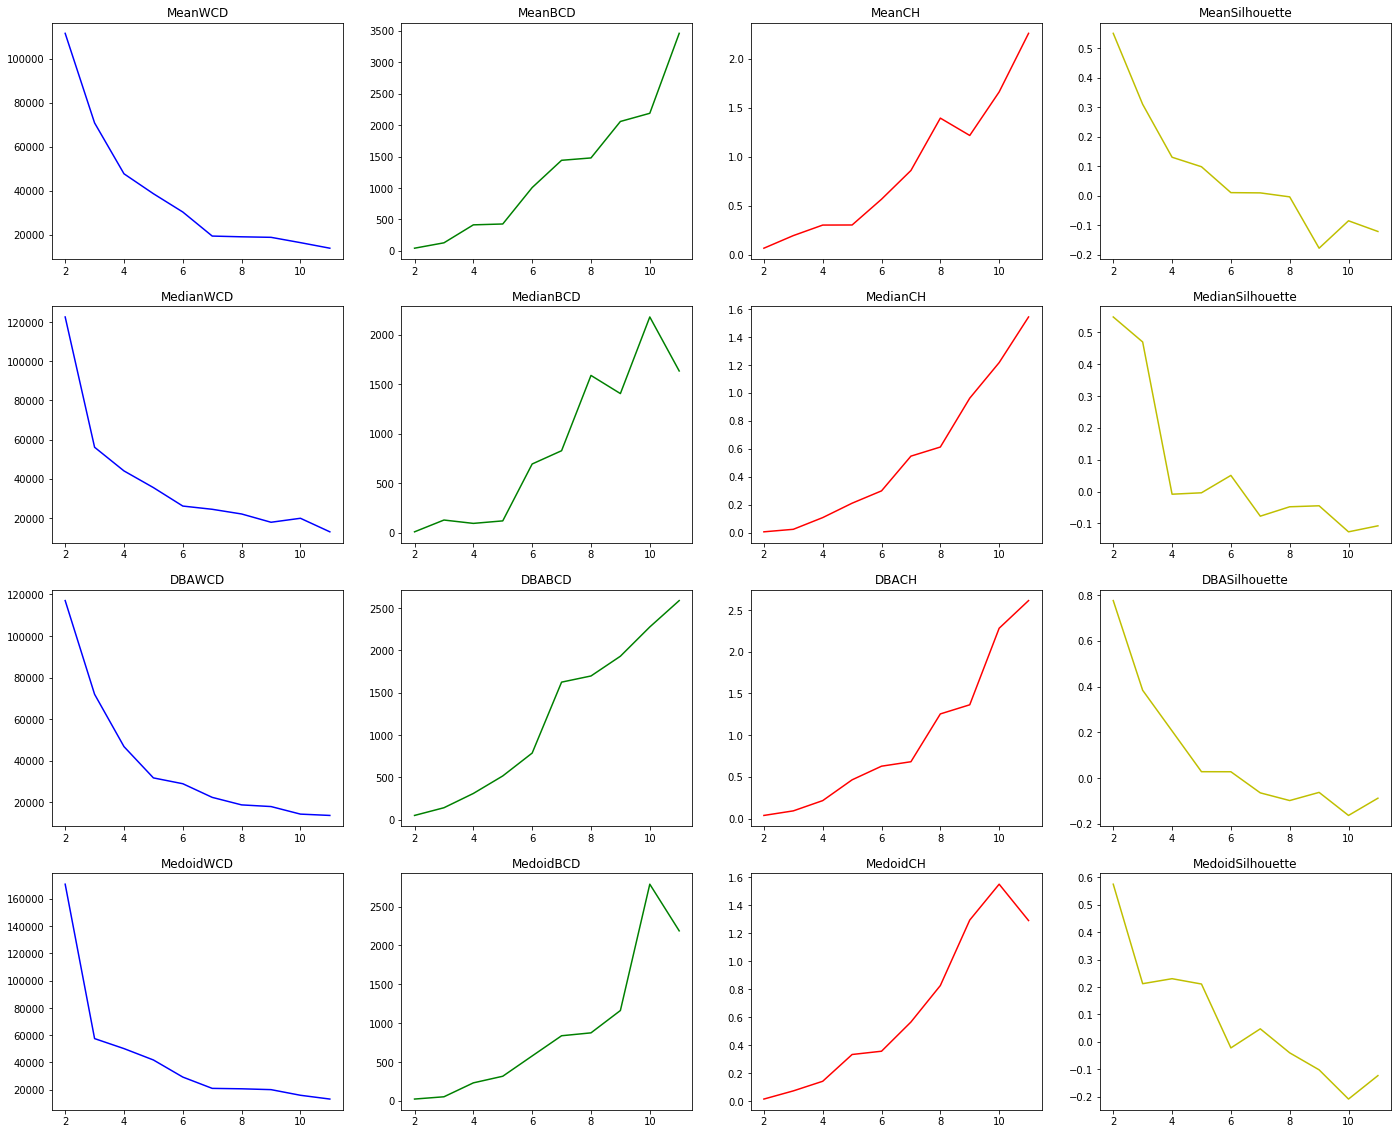

In [293]:
techniques = ['Mean', 'Median', 'DBA', 'Medoid']
metrics = ['WCD', 'BCD', 'CH', 'Silhouette']
colours = ['b', 'g', 'r', 'y']
fig, axs = plt.subplots(4,4, figsize = (24,20))

for i, technique in enumerate([centroid_mean, centroid_median, centroid_DBA, medoid]):
    evals = []
    print('Starting ' + techniques[i])
    for j, metric in enumerate([within_cluster_distances, between_cluster_distances, Calinski_Harabasz, Silhouette]):
        evals.append(evaluate_clustering_technique(df1, features, technique, metric))
        axs[i,j].plot(list(range(2,12)), evals[j], colours[j])
        axs[i,j].set_title(techniques[i]+metrics[j])
    

Observations  
Interestingly, the median and medoid have similar cluster evaluation profiles, and likewise DBA and mean centroid methods look similar. 

For Within Cluster Differences, DBA seems to find lower values for smaller numbers of clusters. Medoid starts off the worst then catches up
For Between Cluster Difference, Mean Centroid seems to be the largest, however this could be due to some of the issues with using arithmetic mean to calculate time-series centroids
(see https://github.com/fpetitjean/DBA for a nice demonstration)

For the Calinski-Harabasz statistic, DBA again has the highest values for small numbers of clusters, which indicates low WCD, high BCD, divided by the number of clusters k
For all techniques the C-H stat rises as the BCD rises and WCD falls. 

The Silhoutte statistic, by contrast to C-H, indicates a lower number of clusters yields a higher quality of clusters, and is the only stat where Medoid performs as well as the others. 
For k <= 4, DBA and Medoid have the best scores, but as the number of clusters decreases, the score decreases rapidly, indicating the clusters overlap. 

Using a combination of the H-C stat and the Silhouette Score, can say that DBA probably provides the best way to use K-Means clustering on this multivariate time-series dataset. 
Will also visualise the centroids to help gain more of an idea of how the clustering techniques differed. 
Would love in the future to compare some more techniques such as K-Shape, however could not find a Python implementation of it which works for multi-dimensional time-series.

Starting Mean
Mean Took 545.4655110836029 seconds to complete
Starting Median
Median Took 549.2520778179169 seconds to complete
Starting DBA
DBA Took 3004.4963505268097 seconds to complete
Starting Medoid
Medoid Took 625.8234050273895 seconds to complete


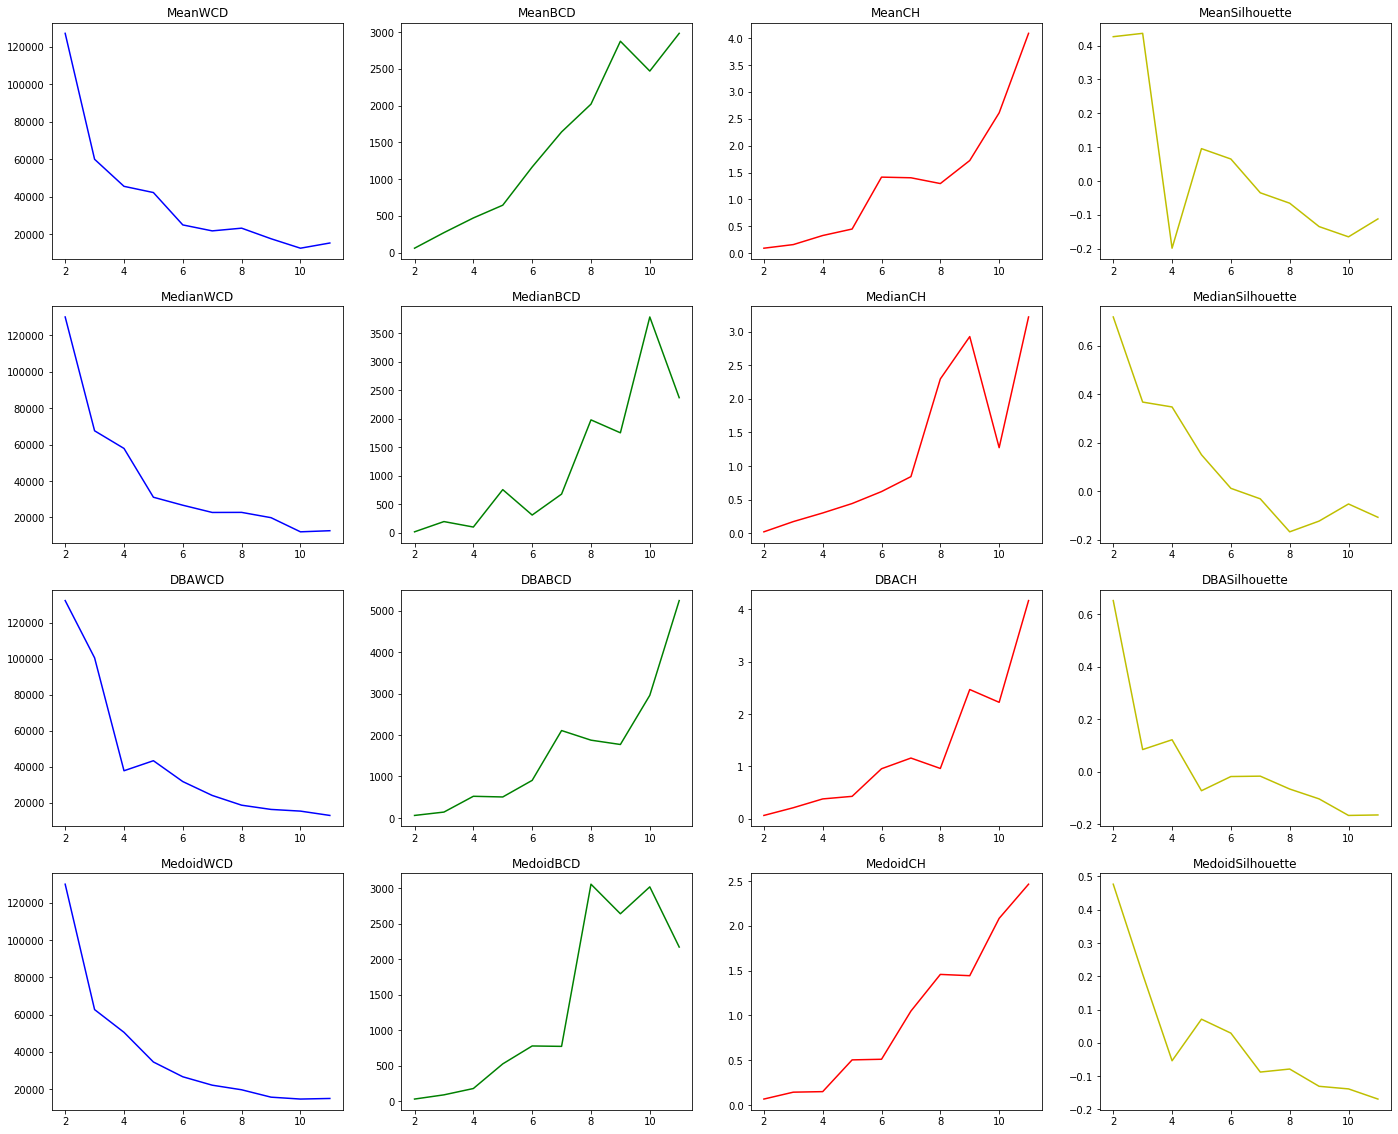

In [324]:
#repeat the same analysis with the total number of successful attacks included as a feature. 


techniques = ['Mean', 'Median', 'DBA', 'Medoid']
metrics = ['WCD', 'BCD', 'CH', 'Silhouette']
colours = ['b', 'g', 'r', 'y']
fig, axs = plt.subplots(4,4, figsize = (24,20))
final_evals = {}
for i, technique in enumerate([centroid_mean, centroid_median, centroid_DBA, medoid]):
    evals = []
    ts = time.time()
    print('Starting ' + techniques[i])
    for j, metric in enumerate([within_cluster_distances, between_cluster_distances, Calinski_Harabasz, Silhouette]):
        evals.append(evaluate_clustering_technique(df1, features, technique, metric))
        axs[i,j].plot(list(range(2,12)), evals[j], colours[j])
        axs[i,j].set_title(techniques[i]+metrics[j])
    final_evals[techniques[i]] = evals
    print(techniques[i]+' Took {} seconds to complete'.format(time.time()-ts))

Can see that Calinski_Harabasz and Silhouette take a LONG time to complete. Complexity is O(nN) and O(nN^2) respectively, and with a distance metric as expensive as DTW, computing the distance matrix for the entire dataset (as is the case for Silhouette) makes it pretty inefficient.
Definitely will look for improvements on the efficiency front. Using LB_Keogh an obvious place to start. 

In [375]:

def best_kmeans(technique,metric,iterations):    
    num_clusters = 5
    i=0
    max_score = 0
    while i < 10:
        centroids, clusters=  kmeans(df1,features, num_clusters,technique, iterations)
        score = metric(clusters,centroids, num_clusters)
        if score > max_score:
            max_score = score
            best_cluster = clusters
            best_centroids = centroids
        i +=1
    print(max_score)
    return best_cluster, best_centroids

In [378]:
for iteration in [10,25,50,100]:
    best_kmeans(centroid_DBA, Calinski_Harabasz, iteration)


0.8100325767266984
1.7267061924078506
1.4810289314653604
1.0919101100550235


In [390]:
DBA_clusters, DBA_centroids = best_kmeans(centroid_DBA, Calinski_Harabasz, 35)

1.147738803489095


In [391]:
DBA_clusters

{4: ['Afghanistan', 'Bahrain', 'Chile', 'Iraq', 'Libya', 'Peru', 'Somalia'],
 0: ['Algeria',
  'Angola',
  'Bolivia',
  'Colombia',
  'Cyprus',
  'Greece',
  'Grenada',
  'Honduras',
  'Ireland',
  'Israel',
  'Kuwait',
  'Malta',
  'Namibia',
  'Pakistan',
  'Panama',
  'Philippines',
  'South Africa',
  'Spain',
  'Sri Lanka',
  'Syria',
  'Thailand',
  'Turkey',
  'United Kingdom',
  'Yemen'],
 2: ['Andorra',
  'Australia',
  'Austria',
  'Barbados',
  'Brazil',
  'Brunei',
  'Canada',
  'Chad',
  'Czech Republic',
  'Democratic Republic of the Congo',
  'Denmark',
  'Dominican Republic',
  'Ethiopia',
  'Gabon',
  'Germany',
  'Guinea',
  'Hong Kong',
  'India',
  'Indonesia',
  'Iran',
  'Italy',
  'Japan',
  'Malaysia',
  'Mauritania',
  'Mexico',
  'Morocco',
  'Myanmar',
  'Netherlands',
  'New Zealand',
  'Norway',
  'Poland',
  'Singapore',
  'South Korea',
  'Sweden',
  'Switzerland',
  'Tanzania',
  'Uganda',
  'United Arab Emirates',
  'United States',
  'Vietnam',
  'Zamb

In [328]:
mean_clusters, mean_centroids = best_kmeans(centroid_mean, Calinski_Harabasz,25)
median_clusters, median_centroids = best_kmeans(centroid_mean, Calinski_Harabasz,25)
medoid_clusters, medoids = best_kmeans(medoid, Calinski_Harabasz,25)

Step: 5 10 <function Calinski_Harabasz at 0x0000025F3C600DC8>
Step: 5 10 <function Calinski_Harabasz at 0x0000025F3C600DC8>
Step: 5 10 <function Calinski_Harabasz at 0x0000025F3C600DC8>


In [392]:
#Want to visualise the centroids of the clusters for different features. Want to find out if the clustering was actually able to separate countries based on the type of attacks
#rather than just the frequency of the attacks, so will look at the categorical features as a proportion of the total successful attacks.

def plot_centroid_features(feat):

    centroids = [mean_centroids,median_centroids,DBA_centroids, medoids]

    fig, axs = plt.subplots(4,len(feat), figsize = (10*len(feat),24))

    for i, technique in enumerate(centroids):
        for j, feature in enumerate(feat):
            for cluster_centroid in technique:
                axs[i,j].plot(list(range(1980,2019)),[year[features.index(feature)]/year[-1] for year in cluster_centroid])

            axs[i,j].legend(list(range(5)))
            axs[i,j].legend(list(range(5)))
            axs[i,j].set_title(techniques[i] +' '+ feature)
            plt.xlabel('year')
            plt.ylabel('successful attacks per million')

C:\Users\james\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


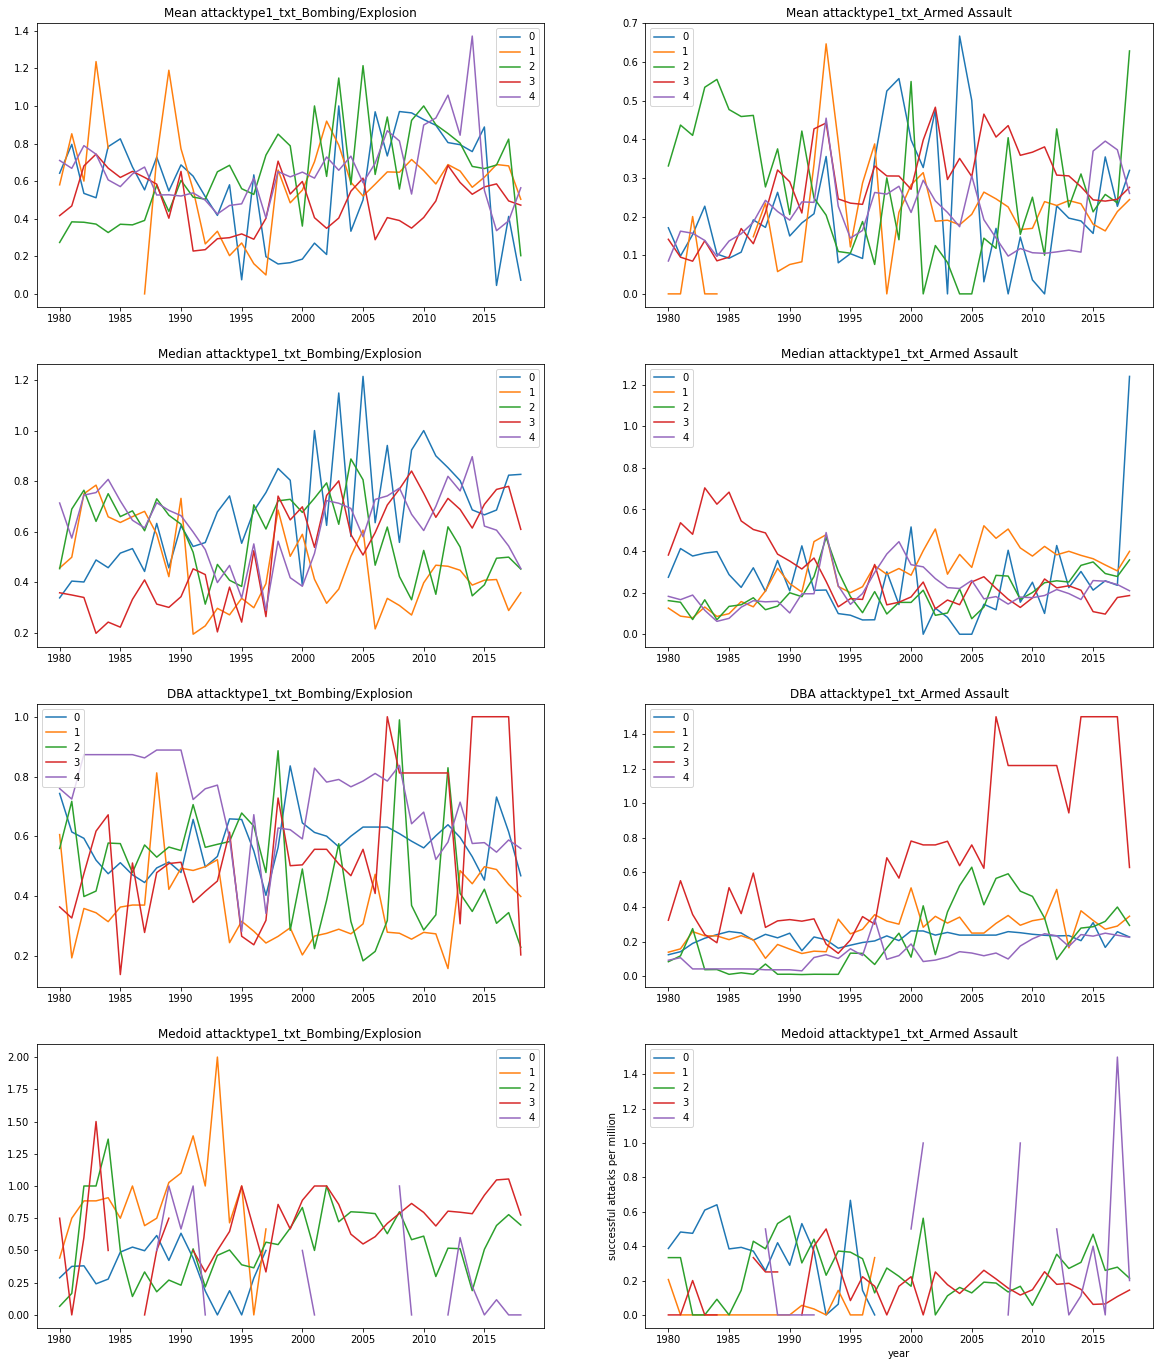

In [393]:
plot_centroid_features(['attacktype1_txt_Bombing/Explosion','attacktype1_txt_Armed Assault'])

First thing that is noticeable is that for Euclidean mean and median, there is a large number of crossings of the centroids. Lots of co-movement

DBA centroids seem more dispersed, less co-movement?

Medoids seem to be missing a lot of values for cluster 4 - need to investigate




C:\Users\james\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


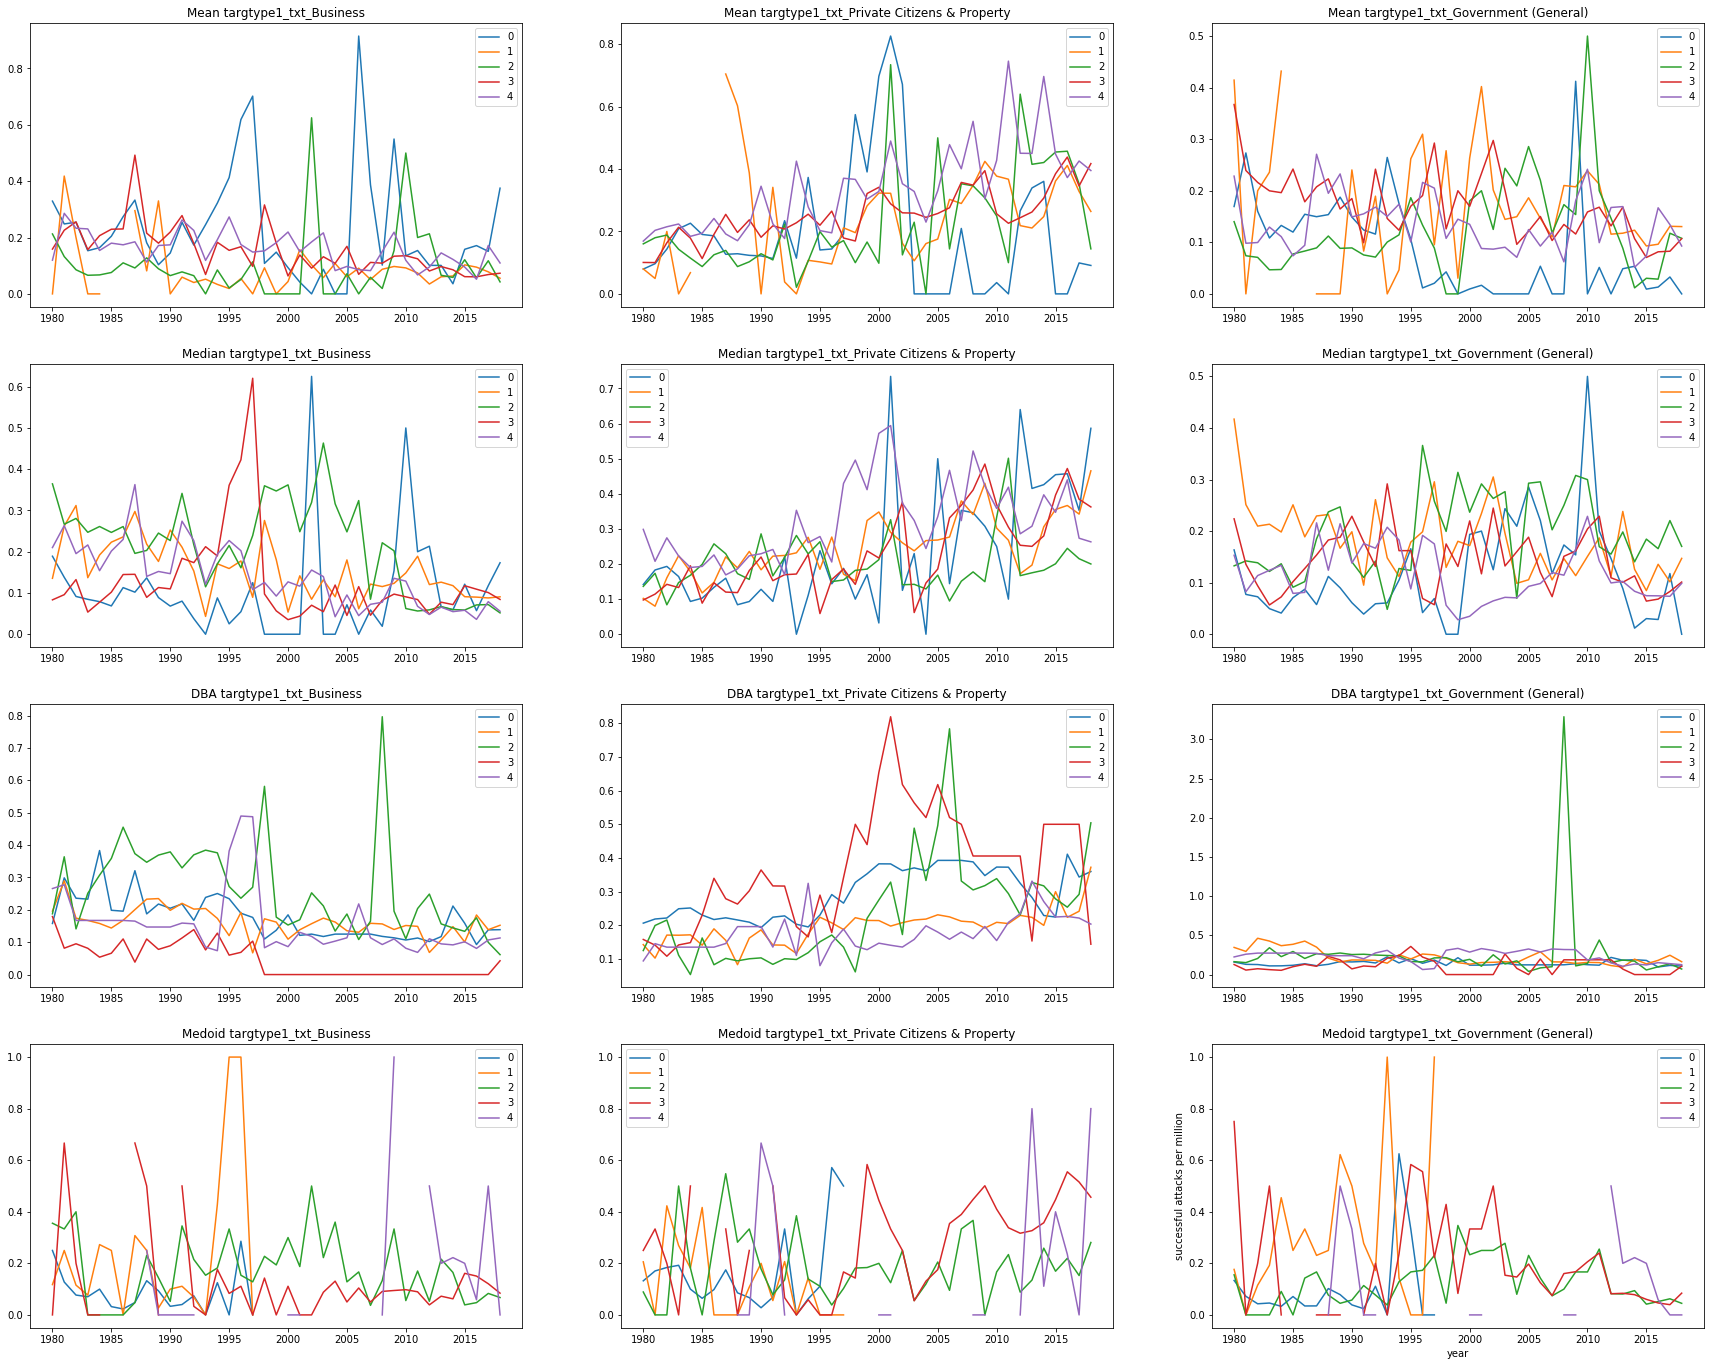

In [394]:
plot_centroid_features(['targtype1_txt_Business','targtype1_txt_Private Citizens & Property','targtype1_txt_Government (General)'])

Can see that the euclidean mean and median centroids are significantly 

DBA centroids for target type are clearly more spaced out than Mean and Median. Could show that DBA is doing a better job of separating the clusters based on this categorical variable. 

To Do:

Proper hyperparameter tuning on num_iterations

If have time, go back and look at feature engineering stage. Is standardising features definitely a bad idea? etc 

Try to link maths of centroid calculation technique to shapes of centroids.

Would like to compare to clustering only on geographical location. 

More efficient distance metrics. 